# Supervised Learning: Text Classification Pipeline

Classification is a primary form of text analysis and is widely used in a variety of
domains and applications. The premise of classification is simple: given a categorical
target variable, learn patterns that exist between instances composed of independent
variables and their relationship to the target. Because the target is given ahead of
time, classification is said to be supervised machine learning because a model can be
trained to minimize error between predicted and actual categories in the training
data. Once a classification model is fit, it assigns categorical labels to new instances
based on the patterns detected during training.

This simple premise gives the opportunity for a huge number of possible applications,
so long as the application problem can be formulated to identify either a yes/no
(binary classification) or discrete buckets (multiclass classification). The most difficult
part of applied text analytics is the curation and collection of a domain-specific
corpus to build models upon. The second most difficult part is composing an analytical
solution for an application-specific problem.

![Supervised](../meta/Classification-Pipeline.png)

# Unsupervised Learning on Text

Unsupervised approaches can be incredibly useful for exploratory text analysis.
Oftentimes corpora do not arrive pretagged with labels ready for classification. In
these cases, the only choice (aside from paying someone to label your data), or at least 
a necessary precursor for many natural language processing tasks, is an unsupervised
approach.

Clustering algorithms aim to discover latent structure or themes in unlabeled data
using features to organize instances into meaningfully dissimilar groups. With text
data, each instance is a single document or utterance, and the features are its tokens,
vocabulary, structure, metadata, etc.

![Unsupervised](../meta/Clustering-Pipeline.png)

A corpus is transformed into feature vectors and a clustering algorithm is employed to create
groups or topic clusters, using a distance metric such that documents that are closer
together in feature space are more similar. New incoming documents can then be
vectorized and assigned to the nearest cluster.

**Data For Unsupervised Learning**

In [1]:
import pandas as pd
import re, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
data = pd.read_json('../meta/NewsHeadlines.json')
data.drop(['url'], axis=1, inplace=True)
print(data.shape)
data.head()

(2345, 1)


,headline
0,Akali Dal’s Manjinder Sirsa shares video from ...
1,"No, Delhi Health Minister is not interacting w..."
2,AIMIM leader Waris Pathan did not threaten cop...
3,March 23 video from Maharashtra shared as Musl...
4,Twitter handles impersonating Arab personaliti...


**Normalization**

In [3]:
remove_punc = lambda x : re.sub(r"\W", ' ', x)
remove_num = lambda x : re.sub(r"\d", ' ', x)
remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)
stop_words = set(nltk.corpus.stopwords.words('english'))
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

def normalize(x):
    x = str(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
    x = remove_stopwords(x)
    return x

In [4]:
data['headline'] = data['headline'].apply(normalize)
data.head()

,headline
0,Akali Dal Manjinder Sirsa shares video Surat l...
1,No Delhi Health Minister interacting Maulana S...
2,AIMIM leader Waris Pathan threaten cops open m...
3,March video Maharashtra shared Muslims gatheri...
4,Twitter handles impersonating Arab personaliti...


**Vectorization**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True)
vectors = vectorizer.fit_transform(data['headline'])
print(vectors.shape)

(2345, 5361)


## Distance Metrics

When we think of how to measure the distance between two points, we usually think
of a straight line, or **Euclidean distance**, represented in Figure as the diagonal line.
**Manhattan distance**, shown in Figure as the three stepped paths, is similar, computed
as the sum of the absolute differences of the Cartesian coordinates. Minkowski
distance is a generalization of Euclidean and Manhattan distance, and defines the distance
between two points in a normalized vector space.
However, as the vocabulary of our corpus grows, so does its dimensionality—and
rarely in an evenly distributed way. For this reason, these distance measures are not
always a very effective measure, since they assume all data is symmetric and that distance
is the same in all dimensions.

![Distances-1](../meta/Distances-1.png)

By contrast, **Mahalanobis distance**, shown in Figure, is a multidimensional generalization
of the measurement of how many standard deviations away a particular
point is from a distribution of points. This has the effect of shifting and rescaling the
coordinates with respect to the distribution. As such, Mahalanobis distance gives us a
slightly more flexible way to define distances between documents; for instance, enabling
us to identify similarities between utterances of different lengths.

![Distances-2](../meta/Distances-2.png)

**Jaccard distance** defines similarity between finite sets as the quotient of their intersection
and their union, as shown in Figure. For instance, we could measure the Jaccard
distance between two documents A and B by dividing the number of unique
words that appear in both A and B by the total number of unique words that appear in
A and B. A value of 0 would indicate that the two documents have nothing in common,
a 1 that they were the same document, and values between 0 and 1 indicating
their relative degree of similarity.

![Distances-3](../meta/Distances-3.png)

**Edit distance** measures the distance between two strings by the number of permutations
needed to convert one into the other. There are multiple implementations of
edit distance, all variations on Levenshtein distance, but with differing penalties for
insertions, deletions, and substitutions, as well as potentially increased penalties for
gaps and transpositions. In Figure 6-6 we can see that the edit distance between
“woodman” and “woodland” includes penalties for one insertion and one substitution.

![Distances-4](../meta/Distances-4.png)

We can also measure vector similarity with cosine distance, using the cosine of the angle between
the two vectors to assess the degree to which they share the same orientation, as
shown in Figure. In effect, the more parallel any two vectors are, the more similar
the documents will be (regardless of their magnitude).
While Euclidean distance is often the default metric used in clustering model hyperparameters,
we frequently find the most success using cosine distance.

![Distances-5](../meta/Distances-5.png)

## Clustering

Partitive clustering and agglomerative clustering are our two main approaches, and both separate
documents into groups whose members share maximum similarity as defined by
some distance metric.

### Partitive Clustering

Partitive methods partition instances into groups that are represented by a central vector (the centroid) or
described by a density of documents per cluster. Centroids represent an aggregated
value (e.g., mean or median) of all member documents and are a convenient way to
describe documents in that cluster.

* k-means clustering

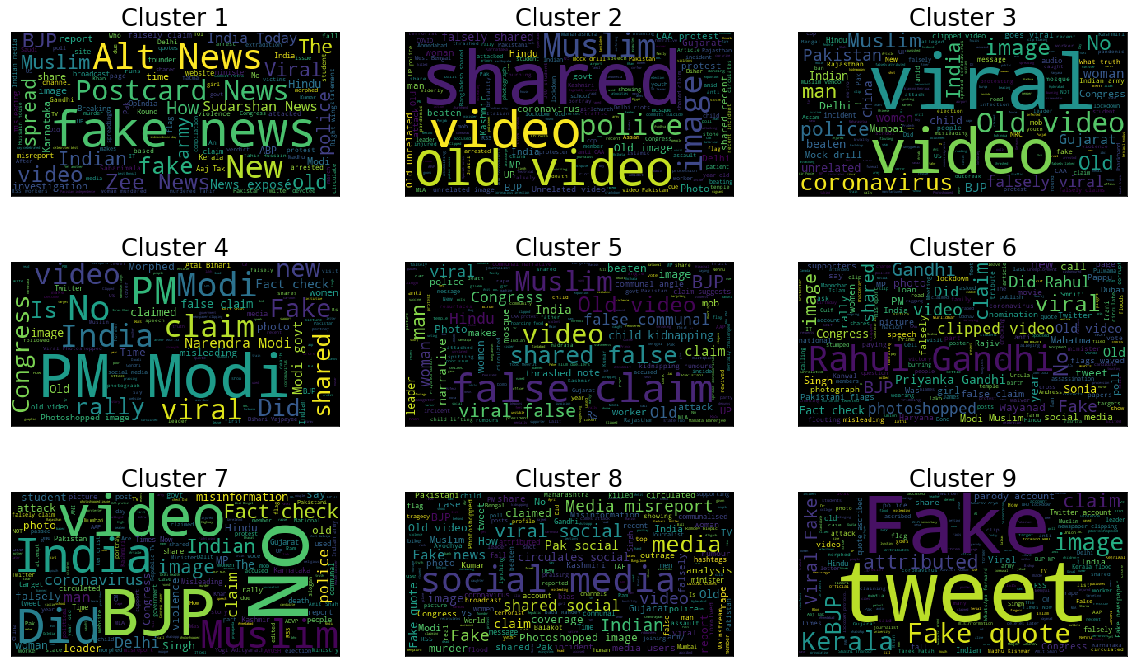

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9)
data['kmeans'] = kmeans.fit_predict(vectors)

fig, ax = plt.subplots(figsize=(20, 12), nrows=3, ncols=3)

for i in range(9):
    wordcloud = WordCloud().generate(' '.join((data[data['kmeans'] == i]['headline'].values)))
    ax[i//3][i%3].imshow(wordcloud)
    ax[i//3][i%3].set_title(f'Cluster {i+1}', fontsize=24)
    ax[i//3][i%3].xaxis.set_visible(False)
    ax[i//3][i%3].yaxis.set_visible(False)

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined
ordering from top to bottom. Hierarchical models can be either
agglomerative, where clusters begin as single instances that iteratively aggregate by
similarity until all belong to a single group, or divisive, where the data are gradually
divided, beginning with all instances and finishing as single instances.
These methods create a dendrogram representation of the cluster structures

* Agglomerative clustering

In [7]:
from scipy.cluster import hierarchy

*Clustering the Kmeans Cluster Centers for the sake of demonstration only*

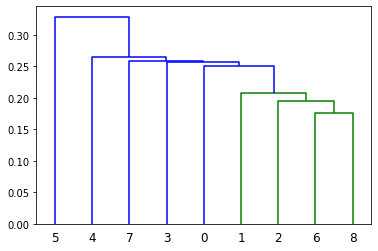

In [8]:
Z = hierarchy.linkage(kmeans.cluster_centers_)
plt.figure()
dn = hierarchy.dendrogram(Z)

*Forming Two Clusters*

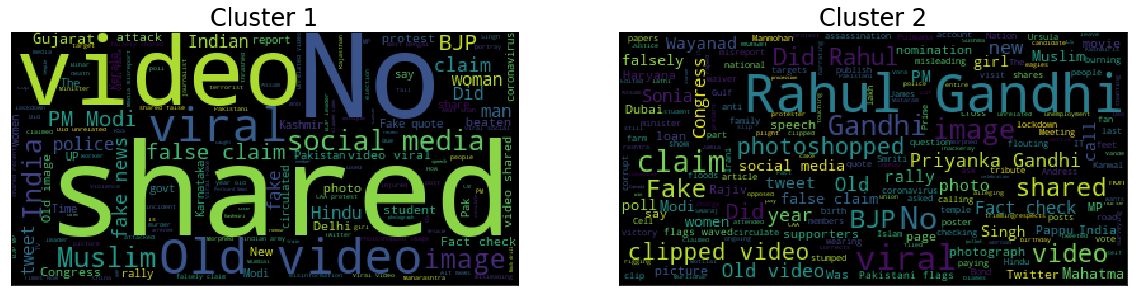

In [9]:
data['agg'] = data['kmeans'].apply(lambda x: 1 if x == 5 else 0)

fig, ax = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)

for i in range(2):
    wordcloud = WordCloud().generate(' '.join((data[data['agg'] == i]['headline'].values)))
    ax[i%2].imshow(wordcloud)
    ax[i%2].set_title(f'Cluster {i+1}', fontsize=24)
    ax[i%2].xaxis.set_visible(False)
    ax[i%2].yaxis.set_visible(False)

## Modeling Document Topics

Now that we have organized our documents into piles, how should we go about labeling
them and describing their contents?

Topic modeling is an unsupervised machine learning technique for abstracting topics from collections
of documents. While clustering seeks to establish groups of documents within a corpus,
topic modeling aims to abstract core themes from a set of utterances; clustering
is deductive, while topic modeling is inductive.

Methods for topic modeling, and convenient open source implementations, have
evolved significantly over the last decade. 

* Latent Dirichlet Allocation (LDA)
* Latent Semantic Analysis (LSA),
* Non-Negative Matrix Factorization (NNMF).

### Latent Dirichlet Allocation

First introduced by David Blei, Andrew Ng, and Michael Jordan in 2003, Latent
Dirichlet Allocation (LDA) is a topic discovery technique. It belongs to the generative
probabilistic model family, in which topics are represented as the probability that
each of a given set of terms will occur. Documents can in turn be represented in
terms of a mixture of these topics. A unique feature of LDA models is that topics are
not required to be distinct, and words may occur in multiple topics; this allows for a
kind of topical fuzziness that is useful for handling the flexibility of language

![LDA](../meta/Latent-Dirichlet-Allocation.png)

Blei et al. (2003) found that the Dirichlet prior, a continuous mixture distribution (a
way of measuring a distribution over distributions), is a convenient way of discovering
topics that occur across a corpus and also manifest in different mixtures within
each document in the corpus.1 In effect, with a Latent Dirichlet Allocation, we are
given an observed word or token, from which we attempt to model the probability of
topics, the distribution of words for each topic, and the mixture of topics within a
document.
To use topic models in an application, we need a tunable pipeline that will extrapolate
topics from unstructured text data, and a method for storing the best model so it can
be used on new, incoming data.


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
class TopicModels_LDA(object):
    
    def __init__(self, n_topics=50):
        """
        n_topics is the desired number of topics
        """
        self.n_topics = n_topics
        self.model = Pipeline([
            ('vect', CountVectorizer()),
            ('model', LatentDirichletAllocation(n_components=self.n_topics)),
        ])
        
    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model
    
    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['vect']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()
        
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
        return topics

In [12]:
lda = TopicModels_LDA(2)
lda.fit_transform(data['headline'])
topics = lda.get_topics()
for topic, terms in topics.items():
    print("Topic #{}:".format(topic+1))
    print(terms)

Topic #1:
['video', 'shared', 'old', 'viral', 'false', 'falsely', 'news', 'claim', 'image', 'media', 'police', 'bjp', 'muslim', 'no', 'social', 'indian', 'coronavirus', 'man', 'images', 'fake', 'gandhi', 'woman', 'modi']
Topic #2:
['fake', 'no', 'modi', 'pm', 'media', 'bjp', 'india', 'news', 'fact', 'claim', 'check', 'claims', 'false', 'viral', 'times', 'social', 'gandhi', 'singh', 'rahul', 'quote', 'did', 'tv', 'congress']


### Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a vector-based approach first suggested as a topic
modeling technique by Deerwester et al in 1990.
While Latent Dirichlet Allocation works by abstracting topics from documents,
which can then be used to score documents by their proportion of topical terms,
Latent Semantic Analysis simply finds groups of documents with the same words.
The LSA approach to topic modeling (also known as Latent Semantic Indexing) identifies
themes within a corpus by creating a sparse term-document matrix, where each
row is a token and each column is a document. Each value in the matrix corresponds
to the frequency with which the given term appears in that document, and can be
normalized using TF–IDF. Singular Value Decomposition (SVD) can then be applied
to the matrix to factorize into matrices that represent the term-topics, the topic
importances, and the topic-documents.

![LSA](../meta/Latent-Semantic-Analysis.png)

Using the derived diagonal topic importance matrix, we can identify the topics that
are the most significant in our corpus, and remove rows that correspond to less
important topic terms. Of the remaining rows (terms) and columns (documents), we
can assign topics based on their highest corresponding topic importance weights.

In [13]:
class TopicModels_LSA(object):

    def __init__(self, n_topics=50):
        """
        n_topics is the desired number of topics
        """
        self.n_topics = n_topics
        self.model = Pipeline([
            ('vect', CountVectorizer()),
            ('model', TruncatedSVD(n_components=self.n_topics))
        ])

    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model
    
    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['vect']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()
        
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
        return topics        

In [14]:
lsa = TopicModels_LSA(2)
lsa.fit_transform(data['headline'])
topics = lsa.get_topics()
for topic, terms in topics.items():
    print("Topic #{}:".format(topic+1))
    print(terms)

Topic #1:
['video', 'shared', 'old', 'viral', 'false', 'claim', 'falsely', 'bjp', 'police', 'media', 'no', 'coronavirus', 'fake', 'man', 'modi', 'social', 'image', 'muslim', 'pm', 'india', 'indian', 'gandhi', 'news']
Topic #2:
['fake', 'news', 'viral', 'media', 'social', 'modi', 'pm', 'no', 'gandhi', 'india', 'claim', 'rahul', 'quote', 'indian', 'did', 'claims', 'false', 'bjp', 'congress', 'alt', 'image', 'photoshopped', 'attributed']


### Non-Negative Matrix Factorization

First introduced by Pentti Paatero and Unto Tapper
(1994) and popularized in a Nature article by Daniel Lee and H. Sebastian Seung
(1999) NNMF has many applications, including spectral data analysis, collaborative
filtering for recommender systems, and topic extraction

![NNMF](../meta/Non-Negative-Matrix-Factorization.png)

In [15]:
class TopicModels_NMF(object):

    def __init__(self, n_topics=50):
        """
        n_topics is the desired number of topics
        """
        self.n_topics = n_topics
        self.model = Pipeline([
            ('vect', CountVectorizer()),
            ('model', NMF(n_components=self.n_topics))
        ])

    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model
    
    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['vect']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()
        
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
        return topics        

In [16]:
nmf = TopicModels_NMF(2)
nmf.fit_transform(data['headline'])
topics = nmf.get_topics()
for topic, terms in topics.items():
    print("Topic #{}:".format(topic+1))
    print(terms)

Topic #1:
['video', 'shared', 'old', 'viral', 'false', 'falsely', 'police', 'claim', 'bjp', 'coronavirus', 'man', 'muslim', 'recent', 'delhi', 'pakistan', 'muslims', 'unrelated', 'woman', 'up', 'image', 'caa', 'indian', 'images']
Topic #2:
['fake', 'news', 'media', 'viral', 'social', 'modi', 'pm', 'no', 'gandhi', 'india', 'image', 'claim', 'indian', 'rahul', 'bjp', 'quote', 'did', 'claims', 'false', 'congress', 'photoshopped', 'alt', 'fact']


### Combining All Models

In [17]:
class TopicModels(object):

    def __init__(self, n_topics=50, vectorizer='TFIDF', estimator='LDA'):
        """
        n_topics is the desired number of topics
        
        To use Binary Vectorizer, set vectorizer to 'BIN',
        To use Count Vectorizer, set vectorizer to 'COUNT',
        otherwise, defaults to TFIDF vectorizer.
        
        To use Latent Semantic Analysis, set estimator to 'LSA',
        To use Non-Negative Matrix Factorization, set estimator to 'NMF',
        otherwise, defaults to Latent Dirichlet Allocation ('LDA').
        
        """
        self.n_topics = n_topics

        if vectorizer == 'BIN':
            self.vectorizer = CountVectorizer(binary=True)
        elif vectorizer == 'COUNT':
            self.vectorizer = CountVectorizer()
        else:
            self.estimator = TfidfVectorizer(sublinear_tf=True)
        
        if estimator == 'LSA':
            self.estimator = TruncatedSVD(n_components=self.n_topics)
        elif estimator == 'NMF':
            self.estimator = NMF(n_components=self.n_topics)
        else:
            self.estimator = LatentDirichletAllocation(n_components=self.n_topics)
        
        self.model = Pipeline([
            ('vect', CountVectorizer()),
            ('model', self.estimator)
        ])

    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model
    
    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['vect']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()
        
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
        return topics        